/home/brittny/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/misc.py:178: RuntimeWarning: invalid value encountered in divide
  y = (s * row_).sum(axis=0) / row.sum()


<Axes: >

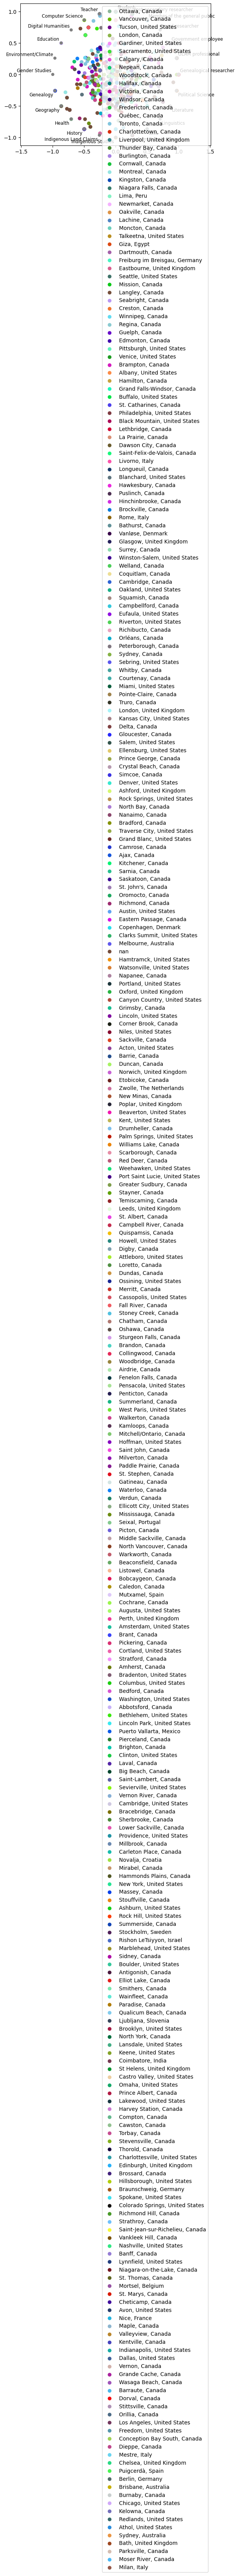

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import radviz
df = pd.read_csv('cleaned.csv')
df = df.drop('id', axis=1)
df = df.drop('Other Identification', axis=1)
df = df.drop('Other Interest', axis=1)
plt.figure()
radviz(df, "geo")

In [2]:
from pandas.plotting import parallel_coordinates
df = pd.read_csv('cleaned.csv')
plt.figure()
parallel_coordinates(data, "geo")

NameError: name 'data' is not defined

<Figure size 640x480 with 0 Axes>

There is a lot more that you can do with outputs (such as including interactive outputs)
with your book. For more information about this, see [the Jupyter Book documentation](https://jupyterbook.org)